# Step 1: Set Desired Values

In [88]:
dataset_dir = 'data/imagenet' # specify which dataset (data/imagenet for images and data/imagenet_grid_2x2 for grids)
sigmas = [0.15] # specify sigma noise values (e.g., 0.15, 0.25, or 0.33) as long as the samples exist for such values
xai_methods = ['LRP'] # specify attribution methods
layers = ['Input']  # specify which layers to explain (e.g., Input or Final)
model = 'resnet18' # specify which model (e.g., resnet18, resnet152, ...etc)
image_indices = sorted([163]) # Nemo # this image is used in our teaser
save_dir = 'figures' # where to save the visualized certified attribution
Ks = [30, 20, 10, 5, 1] # Sparsification values (top K%), the lower, the more important a certified top K pixel is. All values get overlayed.

In [89]:
image_or_grid = 'grid' if 'grid' in dataset_dir else 'images'
sigmas = [f'sigma_{sigma}' for sigma in sigmas]
samples_dir = f'outputs/noisy_samples_chunks/{image_or_grid}'
os.makedirs(save_dir, exist_ok=True)
attr_dict = {sigma: {layer: {xai: {} for xai in xai_methods} for layer in layers} for sigma in sigmas}

# Step 2: Load ImageNet Dataset (first 200 images)

In [82]:
import torch
import torchvision
import os
from attribution_certification.evaluation import utils
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import random
import torch
import pickle
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, to_rgba
import matplotlib

%matplotlib inline
seed = 73
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
current_directory = os.getcwd()
if 'experiments' in current_directory:
    parent_directory = os.path.dirname(current_directory)
    os.chdir(parent_directory)
    
from scripts.utils import *

def load_dataset(dataset_dir, max_images=200):
    test_data_dict = torch.load(os.path.join(dataset_dir, 'test.pt'))
    scale = test_data_dict["scale"]
    img_dims = test_data_dict["input_dims"][1:]
    imagenet_inv_normalize_transform = torchvision.transforms.Normalize(
        mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
        std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
    )
    shuffled_idx = pickle.load(open('data/images_indices.pkl', 'rb'))
    images = imagenet_inv_normalize_transform(test_data_dict["data"][shuffled_idx][:max_images])
    return images, img_dims, scale

dataset_dir = 'data/imagenet'
images, img_dims, scale = load_dataset(dataset_dir, max_images=200)

# Step 3: Load noisy attribution samples (100 samples per image)

In [90]:
caching_dir = 'metadata_dict'
for sigma in sigmas:
    for layer in layers:
        for xai_method in tqdm(xai_methods):
            if 'Cam' in xai_method and layer == 'Input': continue
            if 'Cam' not in xai_method and layer == 'Final': continue
            noisy_samples, raw = fast_load(os.path.join(samples_dir, sigma, layer, xai_method), model=model, im_indices=image_indices)
            raw, scale_factor = process_attributions(raw, 
                                steps_dict=
                                { 
                                'interpolate': {'img_dims': tuple(img_dims), 'scale': scale},
                                'normalize':  {'clip_percentile': 99.5, 'scale_factor': None},
                                'positive': {},
                                })
            noisy_samples = process_attributions(noisy_samples, 
                                steps_dict=
                                {
                                'interpolate': {'img_dims': tuple(img_dims), 'scale': scale},
                                'normalize':   {'clip_percentile': 99.5, 'scale_factor': scale_factor},
                                'positive': {},
                                },
                                return_scale=False)
            attr_dict[sigma][layer][xai_method]['raw'] = raw
            attr_dict[sigma][layer][xai_method]['noisy_samples'] = noisy_samples             

100%|██████████| 1/1 [00:00<00:00,  1.65it/s]


# Step 4: Certify attributions based on the sparsification values Ks, n and tau

In [91]:
ns = [100]
taus = [0.75]
graph_dict = {sigma: {layer:{xai: {K: {n: {tau: {} for tau in taus} for n in ns} for K in Ks} for xai in xai_methods} for layer in layers} for sigma in sigmas}
for sigma, sigma_dict in attr_dict.items():
    for layer, layer_d in sigma_dict.items():
        for xai_method, xai_d in layer_d.items():
            if 'Cam' in xai_method and layer == 'Input': continue
            if 'Cam' not in xai_method and layer == 'Final': continue
            for K in Ks:
                for n in ns:
                    for tau in taus:
                        if 'certified' in graph_dict[sigma][layer][xai_method][K][n][tau]: continue
                        noisy_samples = attr_dict[sigma][layer][xai_method]['noisy_samples']
                        sparsified = process_attributions(noisy_samples, 
                                steps_dict={'sparsify': {'spars_method': 'all_percentile', 'spars_param': [K], 'head_idx': 0}}, return_scale=False)
                        certified = process_attributions(sparsified, 
                                steps_dict={'certify': {'n':n, 'n0':10, 'tau':tau, 'alpha': 0.001, 'head_idx':0}}, return_scale=False)
                        graph_dict[sigma][layer][xai_method][K][n][tau]['certified'] = certified.cpu().numpy()
                        graph_dict[sigma][layer][xai_method][K][n][tau]['raw_spars'] = sparsified.cpu().numpy()
                        graph_dict[sigma][layer][xai_method][K][n][tau]['sparsified'] = sparsified.cpu().numpy()

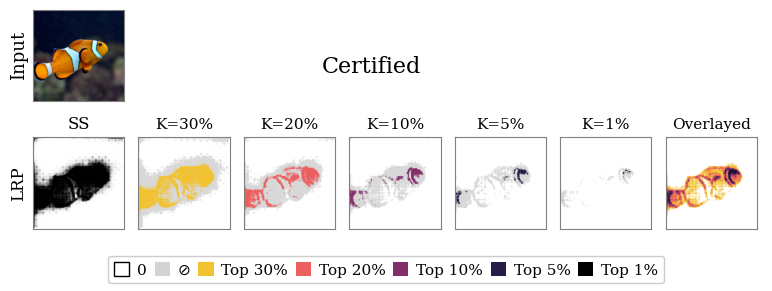

In [ ]:
# Config
fontsize = 14
font = {'family': 'serif', 'weight': 'normal', 'size': fontsize}
matplotlib.rc('font', **font)

# Layout setup
layers = ['Input']
which_im = image_indices[0]
rows_per_image, methods_per_row = 1, 1
methods_layout = [xai_methods[i:i + methods_per_row] for i in range(0, len(xai_methods), methods_per_row)]
col_types = ['mean sparsified'] + [f'K={K}' for K in Ks] + ['overlayed']
features = len(col_types) * len(layers)
num_rows = rows_per_image * len(methods_layout) + 1
num_cols = methods_per_row * features

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(num_cols+1, num_rows+1))
for ax in axes.flatten():
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    for spine in ax.spines.values():
            spine.set_edgecolor('gray')
axes[0,0].set_ylabel('Input', fontsize=fontsize-1, labelpad=10, rotation=90, ha='center', va='center')
for i in range(num_cols-1):
    axes[0, i+1].axis('off')
# Colors
sigma = sigmas[0]
greens = plt.cm.Greens
custom_greens = LinearSegmentedColormap.from_list("custom_greens", [(1, 1, 1)] + [greens(i) for i in range(greens.N)], N=greens.N)
# Fixed anchor colors
anchor_hex_colors = ['#f1c232', '#ec6060', '#842E6A', '#271C48', '#000000']
# Convert to RGBA
anchor_rgba = [mcolors.to_rgba(c) for c in anchor_hex_colors]
# Create a linear segmented colormap from anchor colors
custom_cmap = LinearSegmentedColormap.from_list("custom_anchor_map", anchor_rgba)
# Sample evenly spaced colors based on len(Ks)
color_list = [custom_cmap(i / max(len(Ks)-1, 1)) for i in range(len(Ks))]
inferno_custom = ListedColormap(color_list, name="inferno_custom")
colors = {'abstain': (0.85, 0.85, 0.85, 1), 'bg': (1, 1, 1, 1), 'greens': custom_greens, 'inferno': inferno_custom, 'inferno_ls': color_list}

# Plotting loop
for layer_idx, layer in enumerate(layers):
    for super_row_idx, xai_subset in enumerate(methods_layout):
        for xai_idx, xai_method in enumerate(xai_subset):
            layer = 'Final' if 'Cam' in xai_method else 'Input'
            for idx, im_idx in enumerate(image_indices):
                if im_idx != which_im: continue
                row_idx = super_row_idx + 1
                image = images[im_idx].cpu().numpy().transpose(1, 2, 0)
                axes[0, 0].imshow(image)
                for col_i, col_type in enumerate(col_types):
                    col_idx = xai_idx * len(col_types) + col_i
                    ax = axes[row_idx, col_idx]
                    if col_type == 'mean sparsified':
                        K = Ks[0]
                        attr = graph_dict[sigma][layer][xai_method][K][n][tau]['sparsified'][idx].mean(0).squeeze()
                        ax.imshow(attr, cmap=plt.cm.binary)
                        ax.set_title('SS' if row_idx == 1 else '', fontsize=fontsize - 2)
                        label = {'GradCamPlusPlus': 'GradCam++', 'AblationCam': 'Abl.Cam'}.get(xai_method, xai_method)
                        ax.set_ylabel(label, fontsize=fontsize - 2)
                    elif col_type.startswith('K='):
                        K = int(col_type.replace('K=', ''))
                        cert = graph_dict[sigma][layer][xai_method][K][n][tau]['certified'][idx].squeeze()
                        rgb = get_certified_rgb(cert, cmap=colors['greens'], degrees=[[K]], abstain_color=colors['abstain'],
                                                certified_1_color=colors['inferno_ls'][col_i - 1], certified_0_color=colors['bg'])
                        ax.imshow(rgb)
                        if row_idx == 1: ax.set_title(f'K={K}%', fontsize=fontsize - 3)
                        if col_idx ==2 and row_idx == 1:
                            ax.text(1.4, 1.65, "Certified", fontsize=fontsize+2, ha='center', va='bottom', transform=ax.transAxes)

                    elif col_type == 'overlayed':
                        all_cert = np.zeros((img_dims[0] * scale, img_dims[1] * scale))
                        for deg_idx, K in enumerate(Ks):
                            cert = graph_dict[sigma][layer][xai_method][K][n][tau]['certified'][idx].squeeze()
                            all_cert[cert == 1] = deg_idx + 1
                        rgb = get_certified_rgb(all_cert, cmap=colors['inferno'], degrees=[[K] for K in Ks],
                                                abstain_color=colors['abstain'], certified_0_color=colors['bg'])
                        ax.imshow(rgb)
                        if row_idx == 1: ax.set_title('Overlayed', fontsize=fontsize - 3)

# Formatting
plt.tight_layout(rect=[0, 0, 1, 1])
plt.subplots_adjust(wspace=0.03, hspace=0.4)

# Adjust positions
for row in range(num_rows):
    for col in range(1, num_cols):
        pos = axes[row, col].get_position()
        axes[row, col].set_position([pos.x0 + 0.01, pos.y0, pos.width, pos.height])

# Legend
legend_elements = [
    mpatches.Patch(facecolor='white', edgecolor='black', label='0'),
    mpatches.Patch(facecolor='lightgray', label="$\oslash$")
] + [mpatches.Patch(facecolor=c, label=f'Top {K}%') for c, K in zip(color_list, Ks)]

fig.legend(handles=legend_elements, loc='lower center', bbox_transform=fig.transFigure, ncol=(len(Ks) + 2), frameon=True,
            columnspacing=0.5, handletextpad=0.5, 
           labelspacing=0.5, fontsize=fontsize - 3, framealpha=1,
           handlelength=1.0, handleheight=1.0)
plt.subplots_adjust(bottom=0.2)  # leaves space for the legend
plt.savefig(f'{save_dir}/figure2.png', bbox_inches='tight', dpi=300)
plt.savefig(f'{save_dir}/figure2.pdf', bbox_inches='tight')

plt.show()